In [14]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [15]:
# get europe country name to iso mapping
mapping = pd.read_excel('/home/gidden/work/iiasa/datasources/region_mappings/MESSAGE_regional_coding_20160625.xlsx', index_col=1)
eur = ['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'Sweden', 'United Kingdom']
eur = [mapping.ISO3.loc[c] for c in eur]

# Get Projection Data

In [46]:
# import and clean up
df = pd.read_csv('adjusted_multi_single.csv') # result of smooth.ipynb
df.columns = ['scenario'] + list(df.columns[1:])
df.columns.name = 'iso'

# grab watned columns
df = df[df.scenario.str.startswith(('mSSP', 'std'))]
df.scenario = df.scenario.apply(lambda x: x[1:])
df = df.set_index(['scenario', 'year']).stack().reset_index()#.unstack('year').reset_index()

isos = set(df.iso)

In [47]:
# reduce
#df.iso = df.iso.apply(lambda x: 'EUR' if x in eur else x)
df = df[(df.scenario.isin(['SSP1', 'SSP4', 'td']))]
#df = df[(df.iso.isin(['EUR', 'USA', 'IND', 'CHN']))]
#df = df.groupby(['scenario', 'year', 'iso']).median()
df.head()

,scenario,year,iso,0
0,SSP1,2011,AUT,26.106634
1,SSP1,2011,BEL,27.500149
2,SSP1,2011,BGR,36.457249
3,SSP1,2011,BLR,36.966496
4,SSP1,2011,BOL,54.783241


In [48]:
# clean up std, super hacky, could be cleaned up
df = df.set_index(['scenario', 'year', 'iso'])
std = df.loc['td']
df['std'] = np.nan
df.loc['SSP1']['std'] = std
df.loc['SSP4']['std'] = std
df.columns = ['gini', 'std']
df = df.drop('td')
df['var'] = df['std'] ** 2
projginis = df


In [49]:
projginis.head()

gini        std         var
scenario year iso                                  
SSP1     2011 AUT  26.106634  12.422885  154.328072
              BEL  27.500149  11.115264  123.549094
              BGR  36.457249  11.710701  137.140518
              BLR  36.966496  12.616134  159.166837
              BOL  54.783241  10.866814  118.087647

In [50]:
# bring in income
inc = pd.read_csv('SSP_GDP.csv')
inc.columns = ['year', 'scenario', 'iso', 'inc']
#inc.iso = inc.iso.str.replace('EU15', 'EUR')
inc = inc.set_index(['scenario', 'year', 'iso']).sort_index()
inc.head()

inc
scenario year iso        
SSP1     2005 CHN    4277
              EU15  30221
              IND    2133
              USA   42225
         2010 CHN    7004

In [23]:
# add income, only use years where projections exist
projginis['inc'] = inc
proj = projginis.dropna()
proj['var'] = proj['std'] ** 2
proj.head()

/home/gidden/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


gini        std      inc         var
scenario year iso                                           
SSP1     2020 CHN  44.944191  14.254101  15231.0  203.179395
              EUR  29.309810  11.545145  34250.0  133.290373
              IND  35.485001   8.708382   5079.0   75.835912
              USA  41.544552  11.985305  50642.0  143.647536
         2030 CHN  42.030357  19.975763  28413.0  399.031107

# Get Historical Data

In [51]:
hist = pd.read_csv('Hist_GDP_Gini_Data.csv')
hist.columns = ['iso', 'year', 'gini', 'inc']
hist = hist[hist.year >= 2000]
#hist.iso = hist.iso.apply(lambda x: 'EUR' if x in eur else x)
hist = hist[hist.iso.isin(['EUR', 'USA', 'IND', 'CHN'])]
hist = hist.groupby(['iso', 'year']).median()
hist = hist.interpolate()
hist = hist.reset_index()
hist = hist[hist.year <= 2010]
hist['std'] = 0
hist['var'] = 0
hist.head()

,iso,year,gini,inc,std,var
0,CHN,2000,39.000000,2667.469383,0,0
1,CHN,2001,40.966667,2867.961183,0,0
2,CHN,2002,42.933335,3108.051800,0,0
3,CHN,2003,44.900002,3397.628437,0,0
4,CHN,2004,45.357144,3718.636985,0,0


# Plot

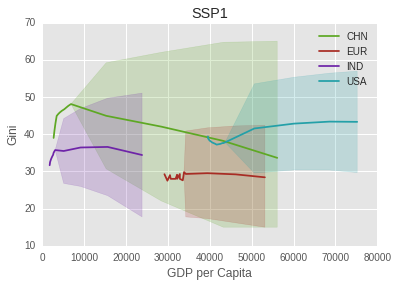

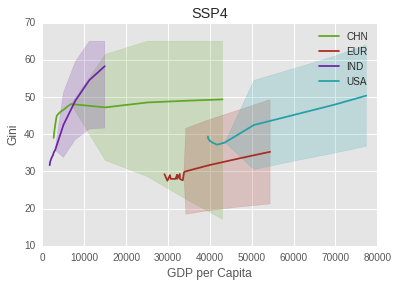

In [25]:
palette = sns.color_palette(sns.hls_palette(n_colors=4, l=.4))
colors = {i: palette.pop() for i in set(hist.iso)}

alldata = proj.reset_index().set_index('scenario')

for ssp in ['SSP1', 'SSP4']:
    df = pd.concat([alldata.loc[ssp], hist])
    df = df.set_index('iso')
    for iso in sorted(set(df.index)):
        data = df.loc[iso].sort_values(by='inc')
        plt.plot(data.inc, data.gini, label=iso.upper(), c=colors[iso])
        lb = (data.gini - data['std']).apply(lambda x: max(x, 15))
        ub = (data.gini + data['std']).apply(lambda x: min(x, 65))
        plt.fill_between(data.inc, lb, ub, alpha=.2, color=colors[iso])
    plt.legend(loc='best')
    plt.xlabel('GDP per Capita')
    plt.title(ssp)
    plt.ylabel('Gini')
    plt.show()
    plt.clf()